In [19]:
import pandas as pd
import numpy as np
import warnings
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [20]:
df = pd.read_pickle('skin_relevant_sentences_train.pkl')

In [37]:
import os
aspects = ['acne','texture','redness', 'wrinkle','sensitive','dark spot']

for aspect in aspects:
    
    basedir = 'bert/bert_amazon2/results/{}/data'.format(aspect.replace(' ','_'))
    for d in ['train','dev','test']:
        os.makedirs('{}_{}'.format(basedir,d))
        
    lname = '{}_label'.format(aspect)
    df2 = df[df[lname].notna()].reset_index(drop=True)
    df_bert = pd.DataFrame({'index':list(range(df2.shape[0]))})
    df_bert['label'] = df2[lname]
    df_bert['label'] = df_bert['label'].replace({0:1,-1:0}).astype('int')
    df_bert['blank'] = 'a'
    df_bert['sentences'] = df2['sent_process']

    x_train, x_val, y_train, y_val = train_test_split(df_bert[['sentences']],df_bert['label'],test_size=.25) 
    ros = RandomOverSampler(random_state=12, ratio = 1.0, sampling_strategy='str')
    x_train_res, y_train_res = ros.fit_sample(x_train, y_train)

    df_bert_train = pd.DataFrame({'index':list(range(x_train_res.shape[0]))})
    df_bert_train['label'] = y_train_res
    df_bert_train['blank'] = 'a'
    df_bert_train['sentences'] = x_train_res

    df_bert_val = pd.DataFrame({'index':list(range(x_val.shape[0]))})
    df_bert_val['label'] = y_val.reset_index(drop=True)
    df_bert_val['blank'] = 'a'
    df_bert_val['sentences'] = x_val.reset_index(drop=True)
    
    test = df[df[aspect]].reset_index()
    df_bert_test = pd.DataFrame({'index':list(range(test.shape[0]))})
    df_bert_test['sentences'] = test['sent_process']

    # TRAINING: SAME EACH TIME
    df_bert_train.to_csv('{}_train/train.tsv'.format(basedir), sep='\t', index=False, header=False)
#     df_bert_train.to_csv('{}_dev/train.tsv'.format(basedir), sep='\t', index=False, header=False)
#     df_bert_train.to_csv('{}_test/train.tsv'.format(basedir), sep='\t', index=False, header=False)
    
    # TEST WITH LABEL: DIFF EACH TIME
#     df_bert_train.to_csv('{}_train/dev.tsv'.format(basedir), sep='\t', index=False, header=False)
    df_bert_val.to_csv('{}_dev/dev.tsv'.format(basedir), sep='\t', index=False, header=False)

    
    # TRUE TEST
    df_bert_train[['index','sentences']].to_csv('{}_train/test.tsv'.format(basedir), sep='\t', index=False, header=True)
    df_bert_val[['index','sentences']].to_csv('{}_dev/test.tsv'.format(basedir), sep='\t', index=False, header=True)
    df_bert_test.to_csv('{}_test/test.tsv'.format(basedir), sep='\t', index=False, header=True)
    test['sample_index'].to_csv('{}_test/test_idx.csv'.format(basedir))

vader
              precision    recall  f1-score   support

           0       0.48      0.29      0.36        34
           1       0.80      0.90      0.85       110

    accuracy                           0.76       144
   macro avg       0.64      0.60      0.61       144
weighted avg       0.73      0.76      0.74       144

textblob
              precision    recall  f1-score   support

           0       0.43      0.18      0.25        34
           1       0.78      0.93      0.85       110

    accuracy                           0.75       144
   macro avg       0.61      0.55      0.55       144
weighted avg       0.70      0.75      0.71       144

bert
              precision    recall  f1-score   support

           0       0.79      0.56      0.66        34
           1       0.88      0.95      0.91       110

    accuracy                           0.86       144
   macro avg       0.83      0.76      0.78       144
weighted avg       0.86      0.86      0.85       144


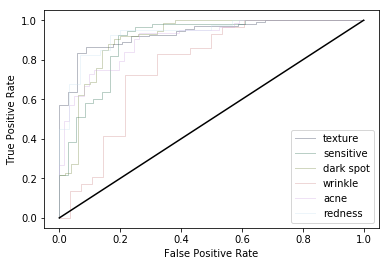

In [76]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

sns.set_palette('cubehelix')
ax = plt.axes()
ttype = 'dev'
output = pd.DataFrame(columns=['score','score_type','model'])

for aspect in aspects: #,'sensitive']:#'redness', 'wrinkle']:
    basedir = 'bert/bert_dev/results/{}/data'.format(aspect.replace(' ','_'))
    train = pd.read_csv('{0}_{1}/{1}.tsv'.format(basedir,ttype),sep='\t',header=-1)
    test = pd.read_csv('{0}_{1}/{1}_results.tsv'.format(basedir,ttype),sep='\t',header=-1)
    train['predicted'] = test[1]
    train = train.rename(columns={1:'true'})
    
    fpr, tpr, thresholds = roc_curve(train['true'],train['predicted'])
    ax.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    analyser = SentimentIntensityAnalyzer()

    train['textblob'] = train[3].apply(lambda x: TextBlob(x).sentiment.polarity)
    train['vader'] = train[3].apply(analyser.polarity_scores)
    train['vader'] = train['vader'].apply(lambda x: x['compound'])
    for p in ['vader','textblob','bert']:
        
        if p=='bert':
            train[p] = np.round(train['predicted'])
        else:
            train.loc[train[p]>=0,p]=1
            train.loc[train[p]<0,p]=0
        d = dict()
        d['model'] = [p]*4
        d['score'] = [accuracy_score(train['true'],train[p]),precision_score(train['true'],train[p]),recall_score(train['true'],train[p]),f1_score(train['true'],train[p])]
        d['score_type'] = ['accuracy','precision','recall','f1']
        tmp = pd.DataFrame.from_dict(d)
        output = output.append(tmp)
        print(p)
        print(classification_report(train['true'],train[p]))


ax.plot([0,1],[0,1],'k')
ax.legend(aspects)
plt.savefig('roc_dev.eps', format='eps')

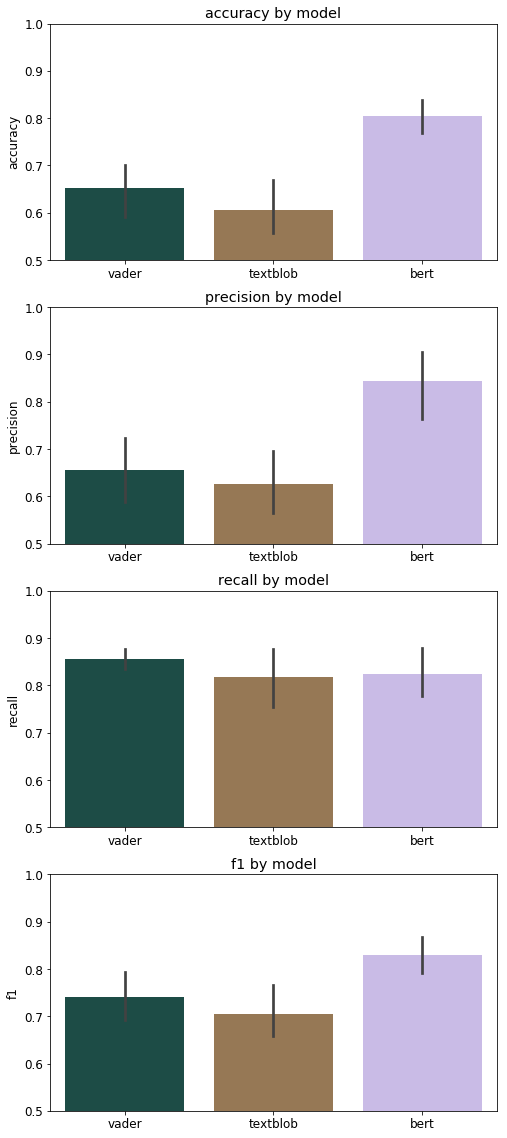

In [87]:
matplotlib.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(output['score_type'].nunique(),1,figsize=(8,20))

for i,score in enumerate(output['score_type'].unique()):
    sns.barplot(data=output[output['score_type']==score],x='model',y='score',palette='cubehelix',ax=ax[i])
    ax[i].set_ylim([.5,1])
    ax[i].set_ylabel(score)
    ax[i].set_xlabel('')
    ax[i].set_title('{} by model'.format(score))
